# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

% matplotlib inline

print(tf.__version__)


# Carregamento de dados

In [ ]:
TRAINING_DATASET_SOURCE = 'training_data.csv'
TEST_DATASET_SOURCE = 'test_data.csv'

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# SEED utilizada

In [ ]:
SEED = 101

# Preparação dos dados

In [ ]:
categorical_to_numerical = {
    'avg_rain': {
        'Sem Chuva': 0,
        'chuva fraca': 1,
        'chuva moderada': 2,
        'chuva forte': 3
    },
    'luminosity': {
        'LOW_LIGHT': 0,
        'LIGHT': 1,
        'DARK': 2,
    }
}

incidents_to_numerical = {
    'incidents': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High': 3,
        'Very_High': 4,
    }
}

In [ ]:
def neural_network_data_preparation(df: pd.DataFrame) -> pd.DataFrame:
    dropped_columns = ['city_name', 'magnitude_of_delay', 'avg_precipitation']

    prep_df = df.drop(dropped_columns, axis=1)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['record_date_hour'] = record_date.hour
    prep_df['record_date_day'] = record_date.day
    prep_df['record_date_month'] = record_date.month
    prep_df['record_date_weekday'] = record_date.weekday

    prep_df.drop(columns=['record_date'], inplace=True)

    ### Quantificar a feature 'affected_roads' para o número único de estradas afetadas
    road_quantity = []
    for line in prep_df['affected_roads']:
        res = set(str(line).split(','))
        res2 = [elem for elem in res if elem != '']
        count = len(res2)
        road_quantity.append(count)

    prep_df['affected_roads'] = road_quantity

    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Target
    if 'incidents' in prep_df.columns:
        prep_df.replace(incidents_to_numerical, inplace=True)

    return prep_df

In [ ]:
X = neural_network_data_preparation(train_df)
y = X['incidents']

X.drop(columns=['incidents'], inplace=True)

In [ ]:
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)

# Construção da estrutura da rede neuronal

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt


def build_model(hp):
    # Create a sequential model (with three layers - last one is the output)
    model = keras.Sequential()

    input_hp_units = hp.Int('units', min_value=5, max_value=200, step=5)

    model.add(Dense(input_hp_units, input_dim=12, activation='relu'))

    hp_units = hp.Int('units', min_value=5, max_value=200, step=5)

    hp_activation = hp.Choice("activation", ["relu", "tanh", 'sigmoid'])

    model.add(Dense(hp_units, activation=hp_activation))

    # Output Layer
    model.add(Dense(5, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

    # Model compilation
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy'])

    return model


In [ ]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="trials",
    project_name="competition",
)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X, y, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X, y, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X, y, epochs=best_epoch, validation_split=0.2)

In [ ]:
eval_result = hypermodel.evaluate(X, y)
print("[test loss, test accuracy]:", eval_result)

-------
-------
-------

In [75]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32)

Epoch 1/150
125/125 [==============================] - 0s 1ms/step - loss: 0.1683 - accuracy: 0.9390 - val_loss: 0.4177 - val_accuracy: 0.8730
Epoch 2/150
125/125 [==============================] - 0s 1ms/step - loss: 0.1661 - accuracy: 0.9383 - val_loss: 0.4167 - val_accuracy: 0.8760
Epoch 3/150
125/125 [==============================] - 0s 1ms/step - loss: 0.1684 - accuracy: 0.9405 - val_loss: 0.4064 - val_accuracy: 0.8780
Epoch 4/150
125/125 [==============================] - 0s 1ms/step - loss: 0.1712 - accuracy: 0.9373 - val_loss: 0.4051 - val_accuracy: 0.8730
Epoch 5/150
125/125 [==============================] - 0s 1ms/step - loss: 0.1634 - accuracy: 0.9442 - val_loss: 0.4072 - val_accuracy: 0.8750
Epoch 6/150
125/125 [==============================] - 0s 1ms/step - loss: 0.1640 - accuracy: 0.9440 - val_loss: 0.4284 - val_accuracy: 0.8700
Epoch 7/150
125/125 [==============================] - 0s 1ms/step - loss: 0.1679 - accuracy: 0.9420 - val_loss: 0.4509 - val_accuracy: 0.8730

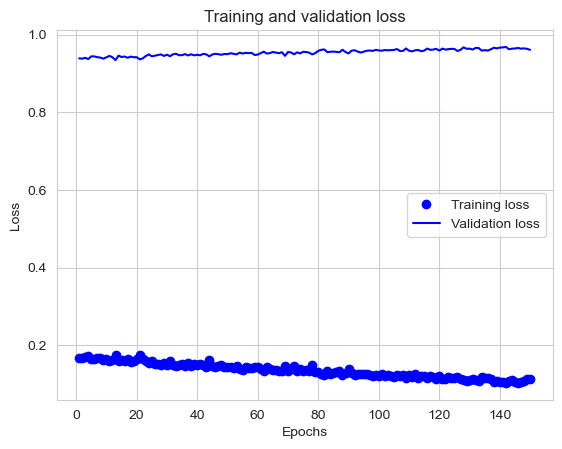

In [76]:
history_dict = history.history

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [77]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 504us/step - loss: 0.4492 - accuracy: 0.8860


In [78]:
predicts = model.predict(X_test)

categories_predicted = [np.argmax(pred) for pred in predicts]

categories_predicted

32/32 [==============================] - 0s 504us/step


[0,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 4,
 2,
 3,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 1,
 1,
 0,
 0,
 3,
 3,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 2,
 2,
 0,
 3,
 3,
 0,
 0,
 0,
 1,
 0,
 1,
 3,
 0,
 4,
 0,
 0,
 0,
 2,
 0,
 4,
 0,
 0,
 2,
 4,
 3,
 0,
 2,
 4,
 3,
 4,
 1,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 3,
 3,
 1,
 4,
 0,
 3,
 0,
 3,
 2,
 4,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 4,
 0,
 1,
 0,
 3,
 1,
 0,
 3,
 0,
 3,
 0,
 3,
 3,
 4,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 4,
 2,
 1,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 3,
 0,
 1,
 0,
 1,
 0,
 0,
 3,
 1,
 3,
 1,
 1,
 4,
 0,
 0,
 1,
 3,
 0,
 3,
 0,
 1,
 1,
 1,
 1,
 4,
 0,
 4,
 0,
 3,
 2,
 3,
 4,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 4,
 2,
 1,
 0,
 3,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 0,
 2,
 0,
 4,
 0,
 0,
 0,
 4,
 4,
 1,
 3,
 1,
 0,
 4,
 3,
 1,
 0,
 2,
 3,
 4,
 0,
 3,
 4,
 2,
 1,
 3,
 0,
 0,
 2,
 0,
 2,


In [79]:
y_test

1718    0
2511    1
345     1
2521    0
54      0
       ..
3900    4
3753    0
3582    3
2392    0
3343    4
Name: incidents, Length: 1000, dtype: int64

# Obter as previsões no dataset de submissão

In [80]:
X = neural_network_data_preparation(test_df)

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

X_scaled

,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,record_date_hour,record_date_day,record_date_month,record_date_weekday
0,0.081461,0.142857,0.5,0.464286,0.59375,0.784946,0.000000,0.0,0.826087,0.400000,0.272727,0.166667
1,0.000000,0.142857,1.0,0.500000,0.59375,0.365591,0.222222,0.0,0.173913,0.400000,0.818182,0.333333
2,0.000000,0.142857,0.5,0.714286,0.56250,0.688172,0.000000,0.0,0.826087,0.566667,0.545455,1.000000
3,0.009417,0.285714,0.5,0.571429,0.28125,0.795699,0.333333,0.0,0.652174,0.966667,0.818182,0.833333
4,0.000000,0.142857,0.5,0.642857,0.71875,0.849462,0.000000,0.0,0.434783,0.566667,0.818182,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1201,0.000000,0.142857,0.5,0.357143,0.81250,0.677419,0.222222,0.0,0.434783,1.000000,1.000000,0.666667
1202,0.002960,0.142857,1.0,0.785714,0.53125,0.344086,0.222222,0.0,0.000000,0.500000,0.545455,0.666667
1203,0.084824,0.142857,0.5,0.392857,0.59375,0.569892,0.000000,0.0,0.652174,0.600000,1.000000,1.000000
1204,0.016548,0.142857,0.5,0.464286,0.50000,0.462366,0.111111,0.0,0.739130,0.233333,0.181818,0.000000


In [81]:
categories_prob_predictions = model.predict(X_scaled)

categories_prob_predictions

38/38 [==============================] - 0s 422us/step


array([[5.57705838e-33, 1.03291772e-15, 9.39767500e-11, 2.20422262e-05,
        9.99977887e-01],
       [9.99352753e-01, 6.47066277e-04, 7.22356930e-08, 6.82782891e-14,
        6.27919685e-17],
       [9.99992073e-01, 3.16565047e-06, 4.60154251e-06, 1.88462683e-11,
        4.76805235e-17],
       ...,
       [2.36871340e-08, 9.08942166e-05, 4.46850155e-03, 9.84091461e-01,
        1.13492105e-02],
       [1.27998962e-19, 9.27853525e-01, 1.29503580e-02, 2.61129085e-02,
        3.30830291e-02],
       [1.94978797e-10, 3.71610440e-07, 3.03487104e-05, 9.99661684e-01,
        3.07561451e-04]], dtype=float32)

In [82]:
numerical_predictions = [np.argmax(pred) for pred in categories_prob_predictions]

numerical_predictions[:10]

[4, 0, 0, 1, 0, 4, 4, 0, 3, 1]

In [83]:
numerical_predictions_df = pd.DataFrame(numerical_predictions)

incidents_categories = {
    0: 'None',
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very_High',
}

predictions_df = numerical_predictions_df.replace(incidents_categories)

In [84]:
predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')